<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Case-X.-Template" data-toc-modified-id="Case-2.-Pneumonia-X-ray-image-analysis"><span class="toc-item-num">1&nbsp;&nbsp;</span>Case 2. Pneumonia X-ray image analysis</a></span></li><li><span><a href="#Background" data-toc-modified-id="Background-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Background</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Models-and-training" data-toc-modified-id="Modes-and-training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models and training</a></span></li><li><span><a href="#Results-and-Discussion" data-toc-modified-id="Results-and-Discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and Discussion</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span></li></ul></div>

# Case 2. Pneumonia X-ray image analysis
Oliver Andersson<br>
Hannu Korhonen<br>
Juho Oksa<br><br>
Team 3<br><br>
Last edited: 01.03.2020<br><br>
Neural Networks for Health Technology Applications<br>
[Helsinki Metropolia University of Applied Sciences](http://www.metropolia.fi/en/)<br>

# Background

In this exercise our aim is to train a convolutional neural network to create a binary classifier to classify x-ray chest images.
<br>
We aim to predict pneumonia from dataset X-ray images.
## Pneumonia
Pneumonia is an inflammatory condition of the lung affecting primarily the small air sacs known as alveoli.<br>
Pneumonia is usually caused by infection with viruses or bacteria.<br>
Pneumonia affects approximately 450 million people globally (7% of the population) and results in about 4 million deaths per year.
## X-ray
A chest radiograph, called a chest X-ray (CXR), or chest film, is a projection radiograph of the chest used to diagnose conditions affecting the chest, its contents, and nearby structures.

# Data

The dataset consists of validated OCT and chest X-ray images and are split into training set and a testing set. The images are further split into two directories; NORMAL for healthy patients and PNEUMONIA for patients suffering from pneumonia.

The dataset used in this exercise is found here: https://data.mendeley.com/datasets/rscbjbr9sj/2

Example image of a NORMAL X-ray


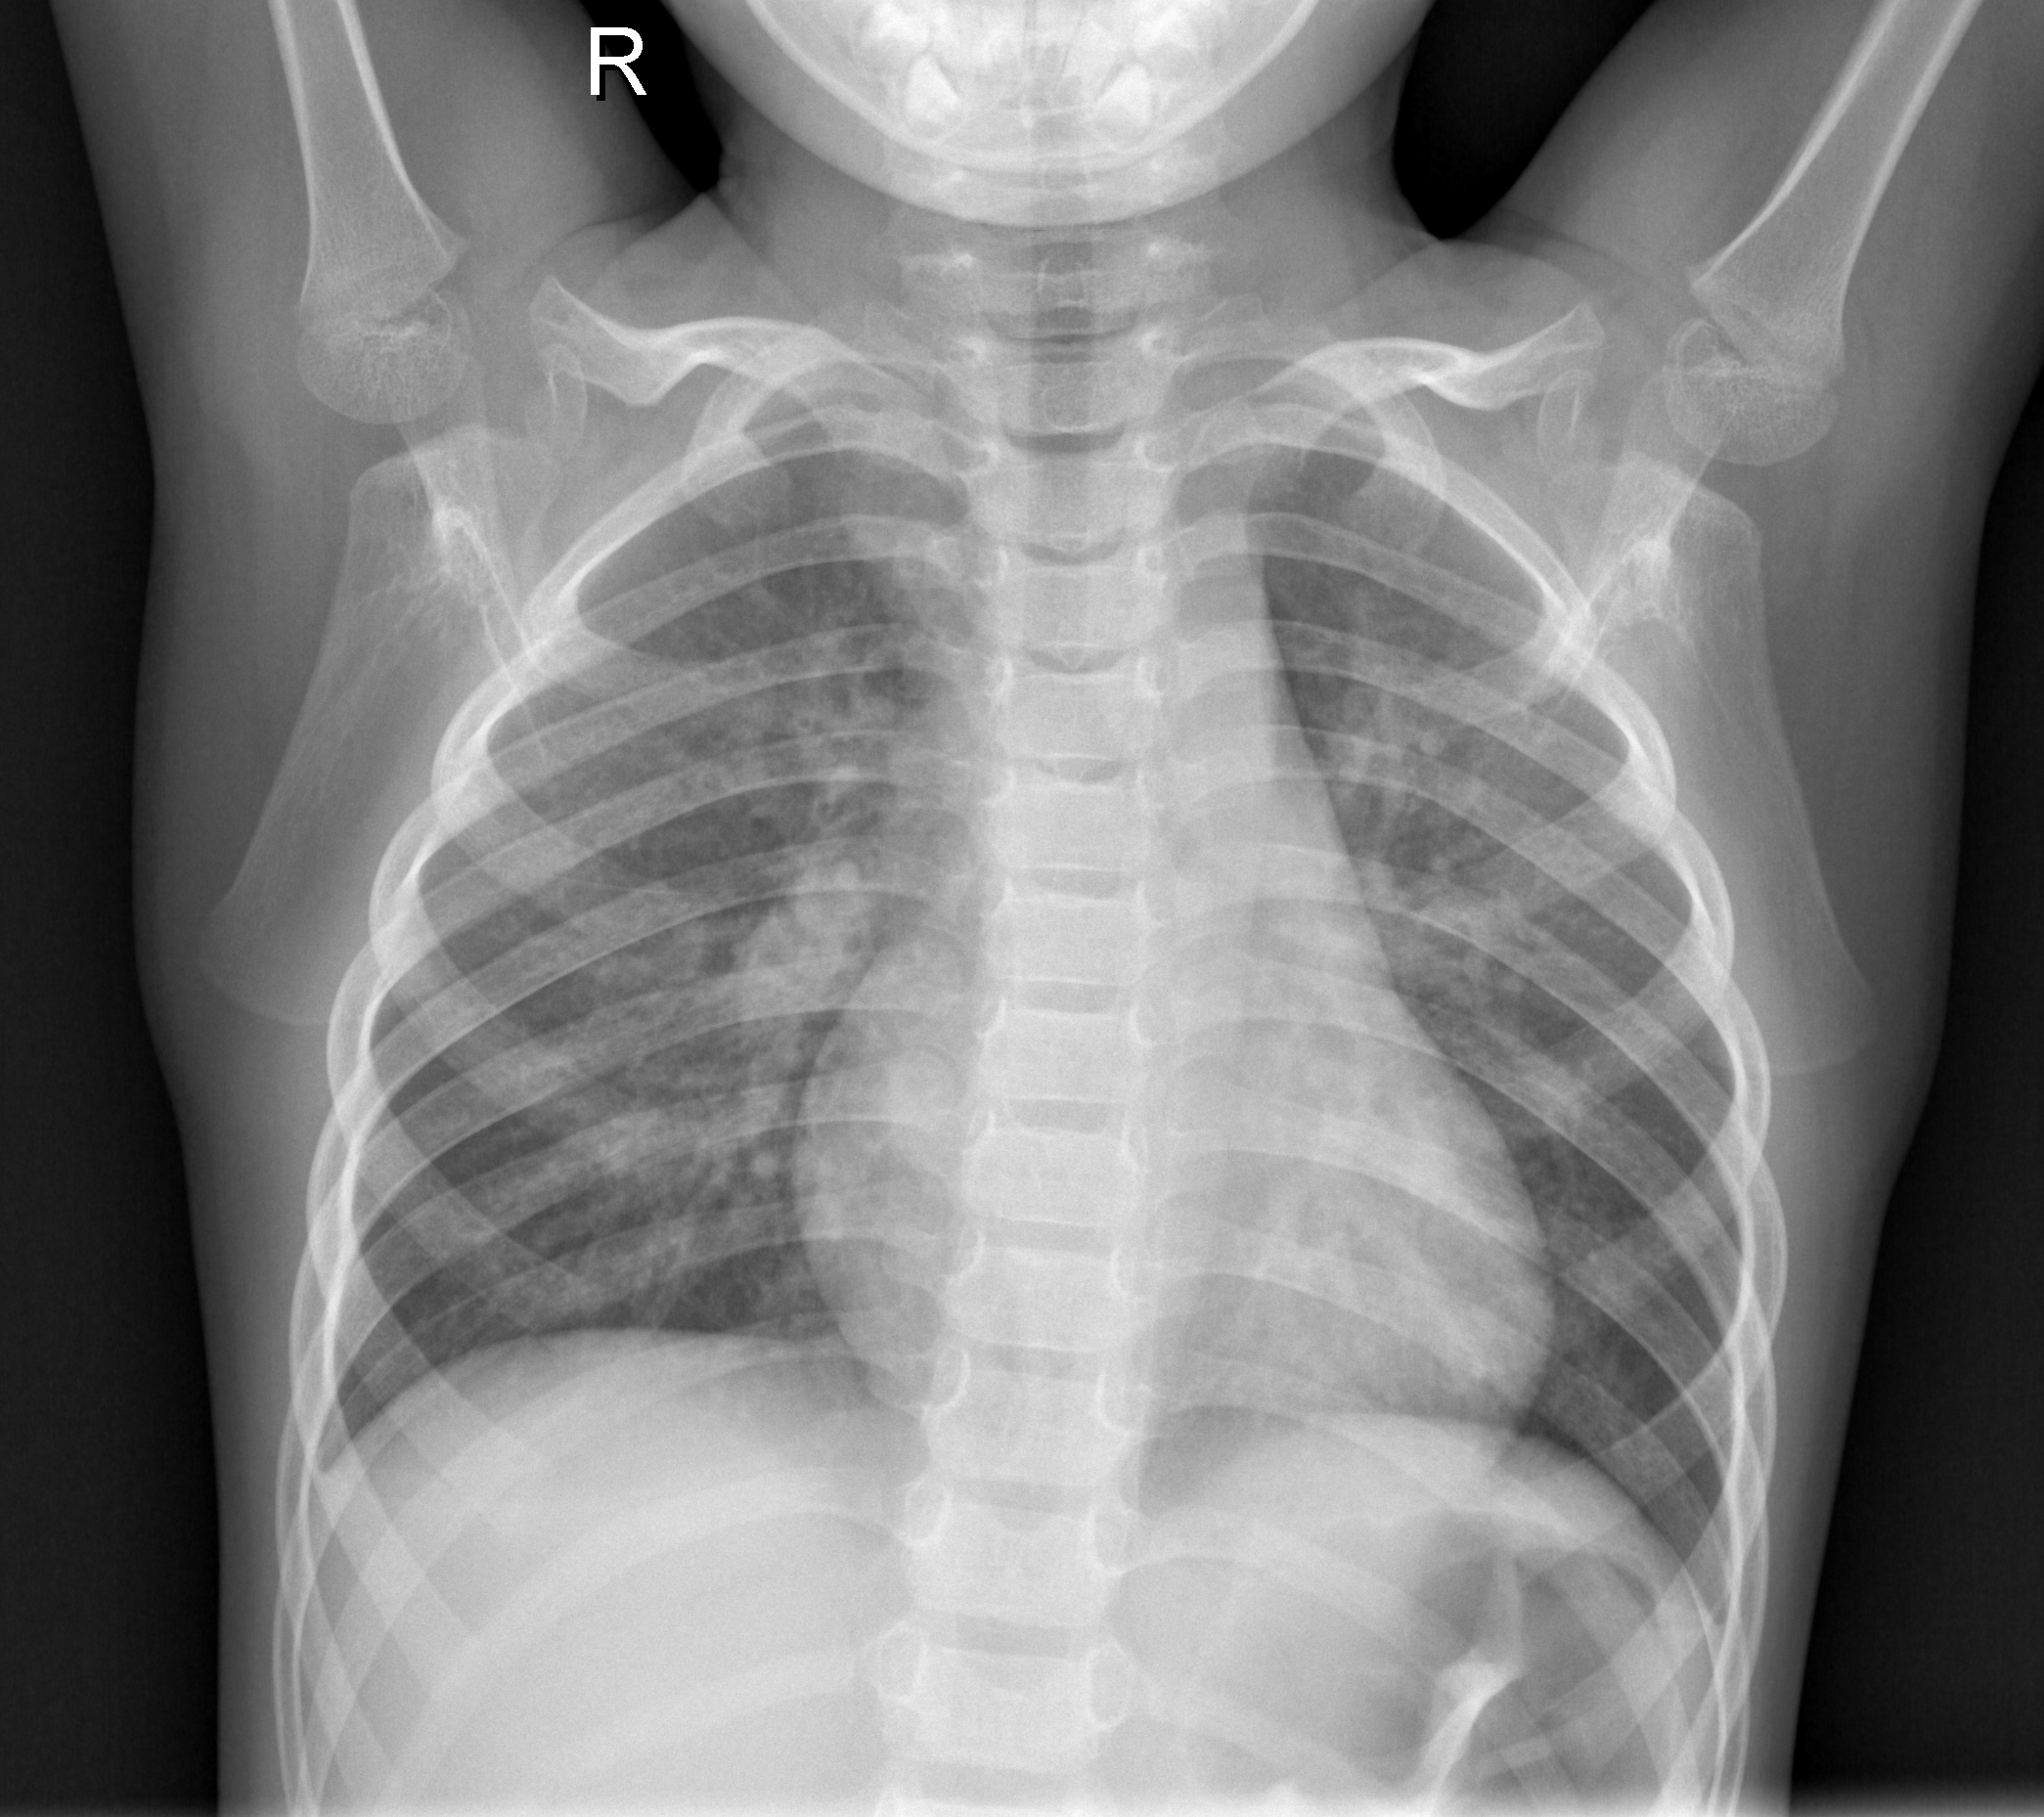

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
print('Example image of a NORMAL X-ray')
PATH = "chest_xray/train/NORMAL/"
Image(filename = PATH + "IM-0115-0001.jpeg", width=200)

Example image of a PNEUMONIA X-ray


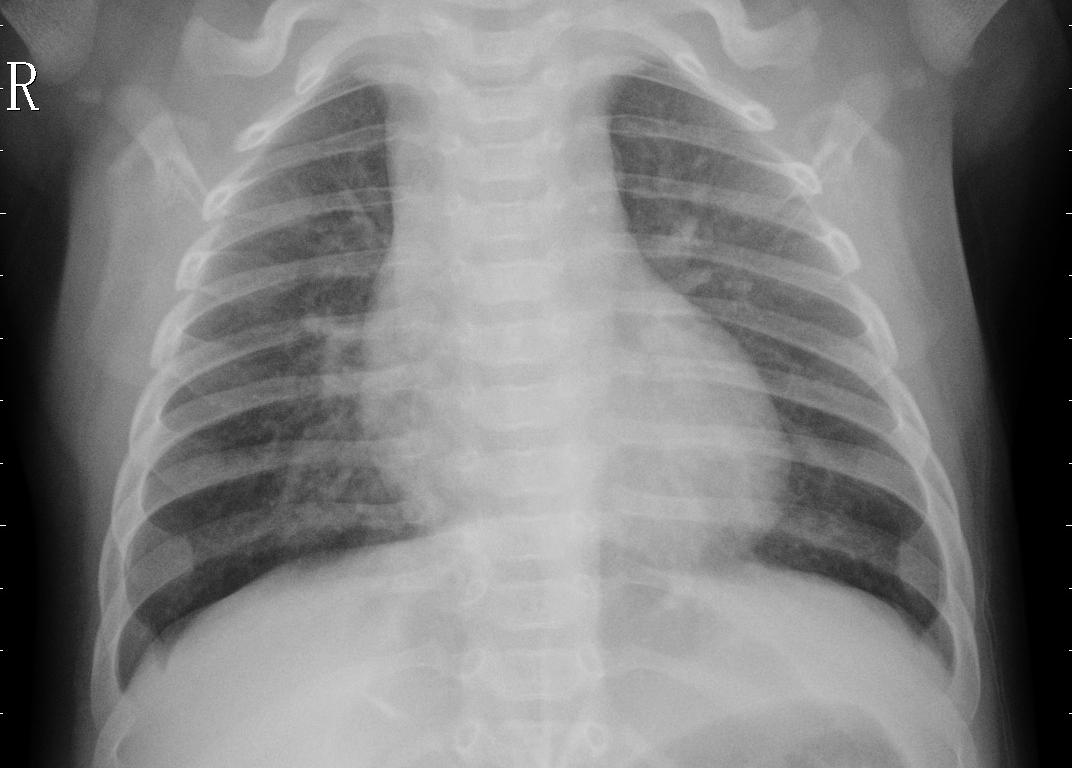

In [2]:
print('Example image of a PNEUMONIA X-ray')
PATH = "chest_xray/train/PNEUMONIA/"
Image(filename = PATH + "person1000_virus_1681.jpeg", width=200)

In [3]:
%pylab inline
import time
import os
import shutil
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy, FalseNegatives, FalsePositives
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
print('Tensorflow version = ', tf.__version__)

Populating the interactive namespace from numpy and matplotlib
Tensorflow version =  1.14.0


We take our original training images from the location "ChestXRay2017/chest_xray/train" and find out that there is a total of 5232 images.

In [4]:
orig_dir = 'chest_xray/train'

normal_images = [x for x in os.listdir(os.path.join(orig_dir, 'NORMAL')) if x.endswith("jpeg")]
pneumonia_images = [x for x in os.listdir(os.path.join(orig_dir, 'PNEUMONIA')) if x.endswith("jpeg")]

N_NORMAL = len(normal_images)
N_PNEUMONIA = len(pneumonia_images)
TOTAL = N_NORMAL + N_PNEUMONIA

print('Original training images:')
print(f'{N_NORMAL:5d} normal cases')
print(f'{N_PNEUMONIA:5d} pneumonia cases')
print(f'{TOTAL:5d} normal totally.')

Original training images:
 1349 normal cases
 3883 pneumonia cases
 5232 normal totally.


Next we create directories for training, validation and testing data.

In [5]:
train_dir = './train'
valid_dir = './validation'
test_dir = './test'
all_dirs = [train_dir, valid_dir, test_dir]
try:
    for d in all_dirs:
        os.mkdir(d)
        os.mkdir(os.path.join(d, 'NORMAL'))
        os.mkdir(os.path.join(d, 'PNEUMONIA'))
except:
    pass
print('Training directory = ', train_dir)
print(os.listdir(train_dir))

Training directory =  ./train
['NORMAL', 'PNEUMONIA']


random.shuffle() reorganizes the lists of images and creates more variation.

In [6]:
random.shuffle(normal_images)
random.shuffle(pneumonia_images)

Next we split our images to smaller sets and divide them to subfolders.

In [7]:
for fname in normal_images[:500]:
    src = os.path.join(orig_dir, 'NORMAL', fname)
    dst = os.path.join(test_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)
    
for fname in normal_images[501:1001]:
    src = os.path.join(orig_dir, 'NORMAL', fname)
    dst = os.path.join(valid_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)

for fname in normal_images[1002:]:
    src = os.path.join(orig_dir, 'NORMAL', fname)
    dst = os.path.join(train_dir, 'NORMAL', fname)
    shutil.copyfile(src, dst)

In [8]:
for fname in pneumonia_images[:500]:
    src = os.path.join(orig_dir, 'PNEUMONIA', fname)
    dst = os.path.join(test_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
    
for fname in pneumonia_images[501:1001]:
    src = os.path.join(orig_dir, 'PNEUMONIA', fname)
    dst = os.path.join(valid_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)
    
for fname in pneumonia_images[1002:]:
    src = os.path.join(orig_dir, 'PNEUMONIA', fname)
    dst = os.path.join(train_dir, 'PNEUMONIA', fname)
    shutil.copyfile(src, dst)

# Models and training

### Model 1

TS resizes our images to 150x150 pixels.

In [58]:
TS = (150, 150)
BS = 64

print('training:')
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

print('Validation:')
devg = ImageDataGenerator(rescale=1./255)
dev_generator = devg.flow_from_directory(
    valid_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

print('Testing:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

training:
Found 3228 images belonging to 2 classes.
Validation:
Found 1000 images belonging to 2 classes.
Testing:
Found 1000 images belonging to 2 classes.


For our first model, we went with less filters and more convolutional layers.

In [59]:
model = models.Sequential()
model.add(layers.Conv2D(24, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(24, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(24, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(24, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(24, (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 24)      672       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 24)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 24)        5208      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 36, 36, 24)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 24)        5208      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 17, 17, 24)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 24)       

We are using SpecificityAtSensitivity as our metric.

In [60]:
model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.RMSprop(),
                 metrics = [tf.keras.metrics.SpecificityAtSensitivity(0.7)])

In [61]:
E = 10
t_start = time.time()

print('Training ...', end='')
h = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 0,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = None
    )

t_end = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/E
print('Done.')
print(f'Time elapsed = {t_elapsed:.0f} seconds.')
print(f'Time per epoch = {t_per_epoch:.2f} seconds.')

Training ...Done.
Time elapsed = 328 seconds.
Time per epoch = 32.82 seconds.


In [64]:
hh = h.history

sas = hh['specificity_at_sensitivity_3']
sas_v = hh['val_specificity_at_sensitivity_3']
loss = hh['loss']
loss_v = hh['val_loss']
epochs = arange(len(loss)) + 1

We plot our models training epochs and see that it trained and validated well.

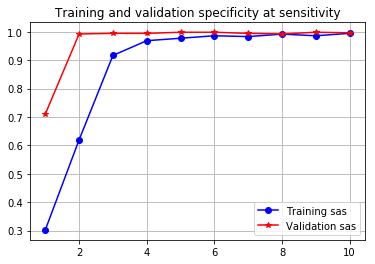

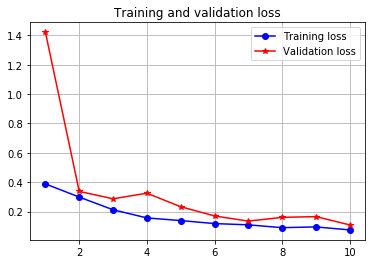

In [65]:
plot(epochs, sas, 'bo-', label='Training sas')
plot(epochs, sas_v, 'r*-', label='Validation sas')
title('Training and validation specificity at sensitivity')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label='Training loss')
plot(epochs, loss_v, 'r*-', label='Validation loss')
title('Training and validation loss')
grid()
legend()

show()

we run the model through our test data.

In [66]:
labels = dev_generator.classes

predicted = model.predict_generator(dev_generator).flatten()

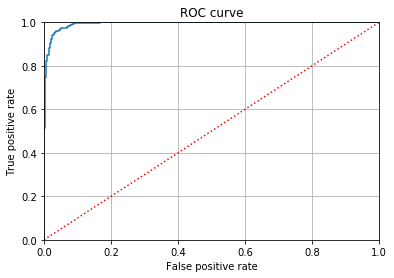

In [68]:
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

From the above graph we see the neural network is performing well.<br><br>

from below we see that the highest points for both specificity is around the 0.5 threshold se we choose that as our divider for positive and negative predictions.

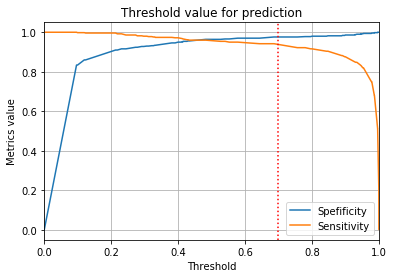

In [69]:
plot(thresholds, 1 - fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.7, color = 'red', linestyle = ':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

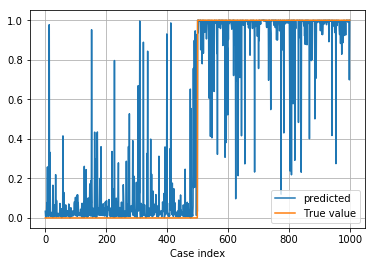

In [70]:
plot(predicted, label = 'predicted')
plot(labels, label = 'True value')
legend()
xlabel('Case index')
grid()

From the confusion matrix and the classification report we see that our model reached around 96% accuracy.

In [73]:
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[482  18]
 [ 21 479]]
Confusion matrix (medicine way):
[[479  21]
 [ 18 482]]


In [74]:
cr = classification_report(labels, predicted > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.96      0.96      0.96       500
Pneumonia (1)       0.96      0.96      0.96       500

    micro avg       0.96      0.96      0.96      1000
    macro avg       0.96      0.96      0.96      1000
 weighted avg       0.96      0.96      0.96      1000



### Model 2

In [27]:
TS = (150, 150)
BS = 64

print('training:')
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

print('Validation:')
devg = ImageDataGenerator(rescale=1./255)
dev_generator = devg.flow_from_directory(
    valid_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

print('Testing:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

training:
Found 3228 images belonging to 2 classes.
Validation:
Found 1000 images belonging to 2 classes.
Testing:
Found 1000 images belonging to 2 classes.


For our second model we went with more filters and less layers.

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(48, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 48)      1344      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 74, 74, 48)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 48)        20784     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 48)        20784     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 17, 17, 48)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 48)       

In [29]:
model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.RMSprop(),
                 metrics = [tf.keras.metrics.SpecificityAtSensitivity(0.4)])

In [30]:
E = 10
t_start = time.time()

print('Training ...', end='')
h = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 0,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = None
    )

t_end = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/E
print('Done.')
print(f'Time elapsed = {t_elapsed:.0f} seconds.')
print(f'Time per epoch = {t_per_epoch:.2f} seconds.')

Training ...Done.
Time elapsed = 455 seconds.
Time per epoch = 45.48 seconds.


In [32]:
hh = h.history

sas = hh['specificity_at_sensitivity_2']
sas_v = hh['val_specificity_at_sensitivity_2']
loss = hh['loss']
loss_v = hh['val_loss']
epochs = arange(len(loss)) + 1

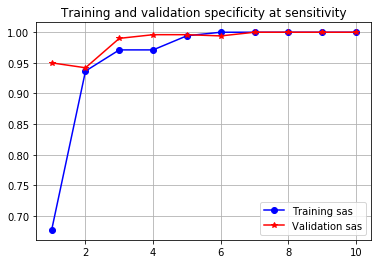

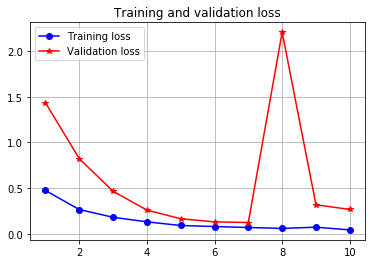

In [33]:
plot(epochs, sas, 'bo-', label='Training sas')
plot(epochs, sas_v, 'r*-', label='Validation sas')
title('Training and validation specificity at sensitivity')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label='Training loss')
plot(epochs, loss_v, 'r*-', label='Validation loss')
title('Training and validation loss')
grid()
legend()

show()

In [34]:
labels = dev_generator.classes

predicted = model.predict_generator(dev_generator).flatten()

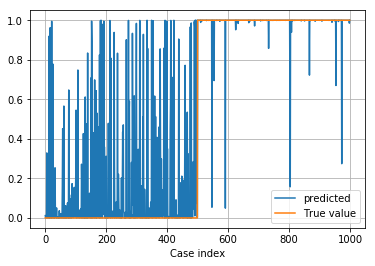

In [35]:
plot(predicted, label = 'predicted')
plot(labels, label = 'True value')
legend()
xlabel('Case index')
grid()

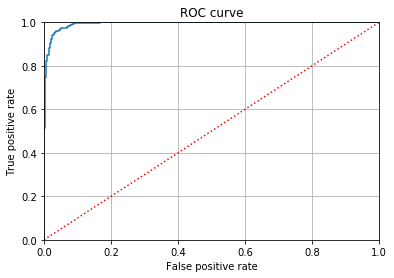

In [75]:
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

Here we see that this model has highest threshold at near 1.

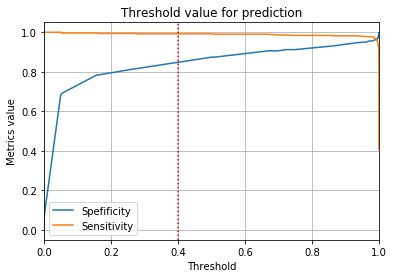

In [54]:
plot(thresholds, 1 - fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.4, color = 'red', linestyle = ':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

In [55]:
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.95)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.95).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[475  25]
 [ 10 490]]
Confusion matrix (medicine way):
[[490  10]
 [ 25 475]]


In [56]:
cr = classification_report(labels, predicted > 0.95, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.98      0.95      0.96       500
Pneumonia (1)       0.95      0.98      0.97       500

    micro avg       0.96      0.96      0.96      1000
    macro avg       0.97      0.96      0.96      1000
 weighted avg       0.97      0.96      0.96      1000



Our second model we ever so slightly more accurate but took more time to train per epoch.

### Model 3

For our third model we used higher resolution for the pictures as well as 5 x 5 filters.

In [80]:
TS = (300, 300)
BS = 64

print('training:')
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

print('Validation:')
devg = ImageDataGenerator(rescale=1./255)
dev_generator = devg.flow_from_directory(
    valid_dir,
    target_size = TS,
    batch_size = BS,
    shuffle = False,
    class_mode = 'binary')

print('Testing:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

training:
Found 3228 images belonging to 2 classes.
Validation:
Found 1000 images belonging to 2 classes.
Testing:
Found 1000 images belonging to 2 classes.


In [81]:
model = models.Sequential()
model.add(layers.Conv2D(15, (5, 5), activation = 'relu', input_shape = (300, 300, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (5, 5), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(15, (5, 5), activation = 'relu'))
model.add(layers.Conv2D(15, (5, 5), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(320, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 296, 296, 15)      1140      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 148, 148, 15)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 144, 144, 15)      5640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 72, 72, 15)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 68, 68, 15)        5640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 34, 34, 15)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 30, 30, 15)       

In [82]:
model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.RMSprop(),
                 metrics = [tf.keras.metrics.SpecificityAtSensitivity(0.4)])

We only trained the model for 5 epochs and can see that the model takes noticably longer to run.

In [83]:
E = 5
t_start = time.time()

print('Training ...', end='')
h = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 0,
    epochs = E,
    validation_data = dev_generator,
    validation_steps = None
    )

t_end = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/E
print('Done.')
print(f'Time elapsed = {t_elapsed:.0f} seconds.')
print(f'Time per epoch = {t_per_epoch:.2f} seconds.')

Training ...Done.
Time elapsed = 1294 seconds.
Time per epoch = 258.73 seconds.


In [85]:
hh = h.history

sas = hh['specificity_at_sensitivity_5']
sas_v = hh['val_specificity_at_sensitivity_5']
loss = hh['loss']
loss_v = hh['val_loss']
epochs = arange(len(loss)) + 1

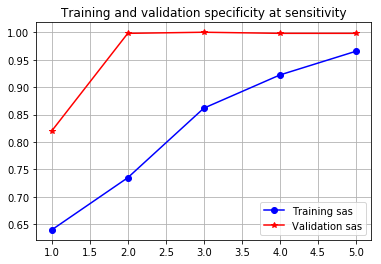

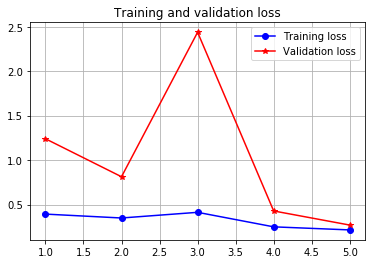

In [86]:
plot(epochs, sas, 'bo-', label='Training sas')
plot(epochs, sas_v, 'r*-', label='Validation sas')
title('Training and validation specificity at sensitivity')
grid()
legend()

figure()
plot(epochs, loss, 'bo-', label='Training loss')
plot(epochs, loss_v, 'r*-', label='Validation loss')
title('Training and validation loss')
grid()
legend()

show()

In [87]:
labels = dev_generator.classes

predicted = model.predict_generator(dev_generator).flatten()

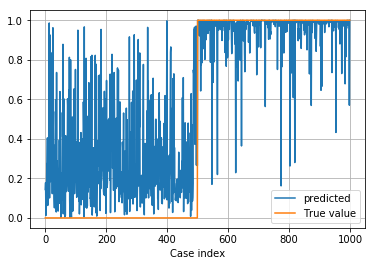

In [88]:
plot(predicted, label = 'predicted')
plot(labels, label = 'True value')
legend()
xlabel('Case index')
grid()

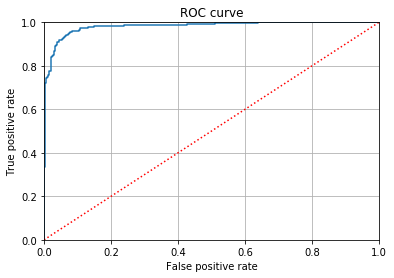

In [89]:
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

For this model the threshold is at around 0.8

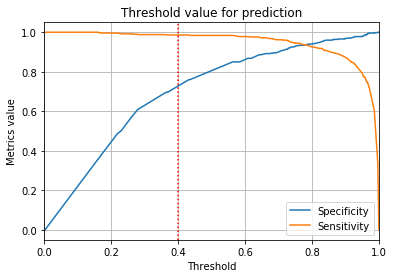

In [90]:
plot(thresholds, 1 - fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.4, color = 'red', linestyle = ':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

In [93]:
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.78)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.78).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[469  31]
 [ 32 468]]
Confusion matrix (medicine way):
[[468  32]
 [ 31 469]]


In [94]:
cr = classification_report(labels, predicted > 0.78, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.94      0.94      0.94       500
Pneumonia (1)       0.94      0.94      0.94       500

    micro avg       0.94      0.94      0.94      1000
    macro avg       0.94      0.94      0.94      1000
 weighted avg       0.94      0.94      0.94      1000



All in all this model took the longest and was the most inaccurate.<br><br>

We chose the second model as our winner.

# Results and Discussion

As this is the final build, we don't need to validate the training data.

In [99]:
TS = (150, 150)
BS = 64

print('training:')
tg = ImageDataGenerator(rescale=1./255)
train_generator = tg.flow_from_directory(
    train_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

print('Testing:')
testg = ImageDataGenerator(rescale=1./255)
test_generator = devg.flow_from_directory(
    test_dir,
    target_size = TS,
    batch_size = BS,
    class_mode = 'binary')

training:
Found 3228 images belonging to 2 classes.
Testing:
Found 1000 images belonging to 2 classes.


In [100]:
model = models.Sequential()
model.add(layers.Conv2D(48, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_34 (Conv2D)           (None, 148, 148, 48)      1344      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 74, 74, 48)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 72, 72, 48)        20784     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 48)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 34, 34, 48)        20784     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 17, 17, 48)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 15, 15, 48)       

We chose the threshold at the level where the model previosly performed the best.

In [101]:
model.compile(loss = 'binary_crossentropy',
                optimizer = optimizers.RMSprop(),
                 metrics = [tf.keras.metrics.SpecificityAtSensitivity(0.95)])

Our model reached the best Specificity at Sensitivity at 7 epochs.

In [102]:
E = 7
t_start = time.time()

print('Training ...', end='')
h = model.fit_generator(
    train_generator,
    steps_per_epoch = None,
    verbose = 0,
    epochs = E,
    )

t_end = time.time()
t_elapsed = t_end - t_start
t_per_epoch = t_elapsed/E
print('Done.')
print(f'Time elapsed = {t_elapsed:.0f} seconds.')
print(f'Time per epoch = {t_per_epoch:.2f} seconds.')

Training ...Done.
Time elapsed = 237 seconds.
Time per epoch = 33.82 seconds.


In [103]:
labels = dev_generator.classes

predicted = model.predict_generator(dev_generator).flatten()

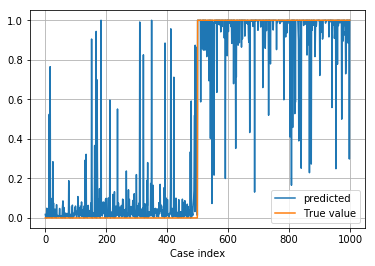

In [104]:
plot(predicted, label = 'predicted')
plot(labels, label = 'True value')
legend()
xlabel('Case index')
grid()

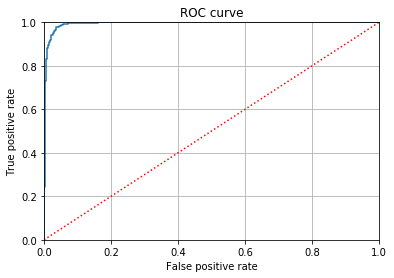

In [105]:
fpr, tpr, thresholds = roc_curve(labels, predicted, pos_label = 1)
plot(fpr, tpr)
plot([0, 1], [0, 1], 'r:')
xlabel('False positive rate')
ylabel('True positive rate')
title('ROC curve')
xlim([0, 1])
ylim([0, 1])
grid()

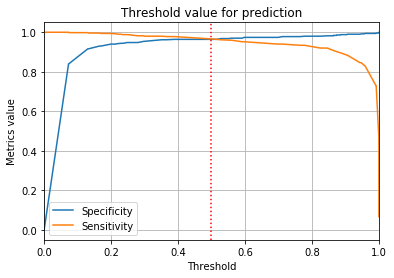

In [111]:
plot(thresholds, 1 - fpr, label = 'Specificity')
plot(thresholds, tpr, label = 'Sensitivity')
axvline(0.5, color = 'red', linestyle = ':')
xlim([0, 1])
title('Threshold value for prediction')
xlabel('Threshold')
ylabel('Metrics value')
legend()
grid()

In [109]:
print('Confusion matrix (machine learning way):')
cm = confusion_matrix(labels, predicted > 0.5)
print(cm)
tn, fp, fn, tp = confusion_matrix(labels, predicted > 0.5).ravel()
print('Confusion matrix (medicine way):')
print(array([[tp, fn], [fp, tn]]))

Confusion matrix (machine learning way):
[[482  18]
 [ 18 482]]
Confusion matrix (medicine way):
[[482  18]
 [ 18 482]]


In [110]:
cr = classification_report(labels, predicted > 0.5, target_names = ['Normal (0)', 'Pneumonia (1)'])
print(cr)

               precision    recall  f1-score   support

   Normal (0)       0.96      0.96      0.96       500
Pneumonia (1)       0.96      0.96      0.96       500

    micro avg       0.96      0.96      0.96      1000
    macro avg       0.96      0.96      0.96      1000
 weighted avg       0.96      0.96      0.96      1000



We can see that our model performed as well as expected.

# Conclusions

For our second neural network exercise we got great results, well over the desired specificity level.
We found out that making a convoluted neural network requires quite a bit of knowledge and trial and error.

Working with large amount of image files made training models take much longer and made mistakes much more impactful.